# TSA d'un EEG i de temperatures

### Imports

In [9]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
from sklearn.datasets import fetch_openml

### Alertes estil

In [11]:
# Activació de les alertes d'estil
%load_ext pycodestyle_magic
%pycodestyle_on

ModuleNotFoundError: No module named 'pycodestyle_magic'

### Lectura de dades

In [ ]:
eeg = fetch_openml(data_id=1471, as_frame=True)
# https://www.openml.org/d/1471
# the whole measurement spans 117 seconds

### Pretractament

In [ ]:
increment = 117 / len(eeg['data'])
fs = len(eeg['data']) // 117

In [ ]:
len(eeg['data'])

14980

In [ ]:
index = np.linspace(start=0,
                    stop=increment*len(eeg['data']),
                    num=len(eeg['data']))

ts_index = pd.to_datetime(index, unit='s')
v1 = pd.Series(name='V1', data=eeg['data']['V1'].values, index=ts_index)

In [ ]:
slicing = (v1.index >= '1970-01-01 00:00:08') & (v1.index <='1970-01-01 00:01:10.000000000')
v1[slicing]

1970-01-01 00:00:08.006208692    4289.74
1970-01-01 00:00:08.014019627    4284.10
1970-01-01 00:00:08.021830562    4280.00
1970-01-01 00:00:08.029641498    4289.74
1970-01-01 00:00:08.037452433    4298.46
                                  ...   
1970-01-01 00:01:09.962547566    4289.74
1970-01-01 00:01:09.970358501    4283.08
1970-01-01 00:01:09.978169437    4284.62
1970-01-01 00:01:09.985980372    4289.23
1970-01-01 00:01:09.993791307    4290.77
Name: V1, Length: 7937, dtype: float64

### Visualització

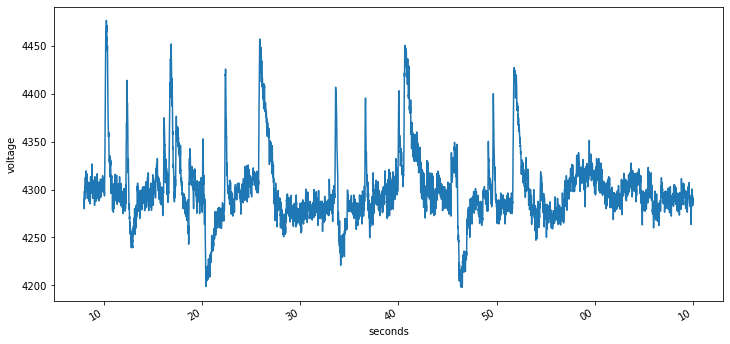

In [ ]:
date_formatter = DateFormatter("%S")
ax = v1[slicing].plot(figsize=(12, 6))
ax.xaxis.set_major_formatter(date_formatter)
plt.ylabel('voltage')
plt.xlabel('seconds')

### Visualització segons resampling

In [ ]:
plt.subplot(311)
ax1 = v1[slicing].resample('1s').mean().plot(figsize=(12, 6))
ax1.xaxis.set_major_formatter(date_formatter)
plt.subplot(312)
ax1 = v1[slicing].resample('2s').mean().plot(figsize=(12, 6))
ax1.xaxis.set_major_formatter(date_formatter)
plt.subplot(313)
ax2 = v1[slicing].resample('5s').mean().plot(figsize=(12, 6))
ax2.xaxis.set_major_formatter(date_formatter)
plt.xlabel('seconds');

### Visualització de l'espectre de potència

In [ ]:
f, Pxx_den = signal.welch(v1[slicing].values,
                          fs,
                          nperseg=4000,
                          scaling='spectrum')

In [ ]:
f, Pxx_den = signal.welch(v1[slicing].values,
                          fs,
                          nperseg=2048,
                          scaling='spectrum')
plt.figure(figsize=(12, 6))
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('Power Spectrum')

## EEG

### Lectura de dades

Es fa un pivoting per a fixar el timeindex

In [ ]:
temperatures = pd.read_csv('monthly_csv.csv')
temperatures['Date'] = pd.to_datetime(temperatures['Date'])
temperatures = temperatures.pivot('Date', 'Source', 'Mean')

In [ ]:
temperatures['GCAG'].index.month

### Funcions per a la tendència i estacionalitat

In [ ]:
from numpy import polyfit

# fit polynomial: E = \sum_{j=0}^k |p(x_j) - y_j|^2

def fit(X, y, degree=3):
    """
    Ajusta de forma genèrica un polinomi de grau degree a X, y.
    Utilitza la funció polyfit de Numpy
    Args:
        X (list): Valors de les abcises
        y (list): Valors de les ordenades
        degree (int, optional): grau del polinomi a ajustar. Per defecte 3.

    Returns:
        trendpoly (funció) : Funció polinòmica ajustada
    """
    coef = polyfit(X, y, degree)
    trendpoly = np.poly1d(coef)
    return trendpoly(X)


def get_season(s, yearly_periods=4, degree=3):
    """
    Calcula l'estacionalitat
    Args:
        s (pd_series): Sèrie temporal de la que calcularem l'estacionalitat
        degree (int, optional): Grau del polinomi per ajustar l'estacionalitat. Defaults to 3.

    Returns:
        (pd_series): Sèrie temporal corresponent a l'estacionalitat
    """
    X = [i%(365/4) for i in range(0, len(s))]
    seasonal = fit(X, s.values, degree)
    return pd.Series(data=seasonal, index=s.index)


def get_trend(s, degree=3):
    """
    Calcula la tendència en una sèrie
    Args:
        s (pd_series): Sèrie temporal de la que calcularem la tendència
        degree (int, optional): Grau del polinomi per ajustar la tendència. Defaults to 3.

    Returns:
        (pd_series): Sèrie temporal corresponent a la tendència
    """
    X = list(range(len(s)))  # (s.index.year - s.index.year.min()).values
    trend = fit(X, s.values, degree)
    return pd.Series(data=trend, index=s.index)

In [ ]:
plt.figure(figsize=(12, 6))
temperatures['trend'] = get_trend(temperatures['GCAG'])
temperatures['season'] = get_season(temperatures['GCAG'] - temperatures['trend'])
sns.lineplot(data=temperatures[['GCAG', 'season', 'trend']])
plt.ylabel('Temperature change')